In [30]:
!pip install mamba-ssm

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn import functional as F
from tqdm import tqdm

import math
import os
import urllib.request
from zipfile import ZipFile

from mamba_ssm import Mamba

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [32]:
def pre_train(model, data_loader, optimizer, criterion, device, dtype):
    model.train()
    total_loss = 0
    loss_list = []
    average_loss = 0
    for i, batch in enumerate(data_loader):
        optimizer.zero_grad()

        input_data = batch['sequences'].clone().detach().to(device=device, dtype=dtype)
        target = batch['target'].clone().detach().to(device=device, dtype=dtype)

        output = model(input_data)
        loss = criterion(output, target)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)

        optimizer.step()

        total_loss += loss.item()
        loss_list.append(loss.item())
    return total_loss / len(data_loader), loss_list

In [33]:
def fine_tune_1(model, data_loader, optimizer, criterion, device, dtype):
    model.train()
    total_loss = 0
    loss_list = []
    average_loss = 0
    for i, batch in enumerate(data_loader):
        optimizer.zero_grad()

        input_data = batch['sequences'].clone().detach().to(device=device, dtype=dtype)
        target = batch['target'].clone().detach().to(device=device, dtype=dtype)

        output = model(input_data)
        loss = criterion(output[:, -2:, 2],
                         target[:, -2:, 2])

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)

        optimizer.step()

        predicted_signs = torch.sign(output[:, -1, 2])
        target_signs = torch.sign(target[:, -1, 2])

        total_loss += loss.item()
        loss_list.append(loss.item())
    return total_loss / len(data_loader), loss_list,

In [34]:
def fine_tune_2(model, data_loader, optimizer, criterion, device, dtype):
    model.train()
    total_loss = 0
    loss_list = []
    average_loss = 0
    total_accuracy = 0
    for i, batch in enumerate(data_loader):
        optimizer.zero_grad()

        input_data = batch['sequences'].clone().detach().to(device=device, dtype=dtype)
        target = batch['target'].clone().detach().to(device=device, dtype=dtype)

        output = model(input_data)
        loss = criterion(output[:, -1, 2],
                         target[:, -1, 2])

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)

        optimizer.step()

        predicted_signs = torch.sign(output[:, -1, 2])
        target_signs = torch.sign(target[:, -1, 2])
        accuracy = (predicted_signs == target_signs).float().mean().item()

        # Accumulate accuracy over batches
        total_accuracy += accuracy

        total_loss += loss.item()
        loss_list.append(loss.item())
    return total_loss / len(data_loader), loss_list, total_accuracy / len(data_loader)

In [35]:
import pandas as pd
import numpy as np

def create_sequences(data, columns, sequence_length=100):
    """
    Create sequences of length 'sequence_length' from time series data.

    Parameters:
    - data: pandas DataFrame, the time series data with rows as time steps
    - columns: list of str, the names of the 5 columns to use
    - sequence_length: int, the length of each sequence

    Returns:
    - sequences: numpy array of shape (num_sequences, sequence_length, 5)
    """

    # Select the 5 columns
    data_selected = data.loc[:, columns]

    # Convert to numpy array
    data_array = data_selected.values  # shape (num_time_steps, 5)
    data_array = data_array.astype(np.float64)
    manipulated = np.zeros((data_array.shape[0] - 2, 4))
    manipulated[:, 0] = data_array[2:, 0] / data_array[2:, 3]
    manipulated[:, 1] = data_array[2:, 1] / data_array[2:, 2]
    manipulated[:, 2] = np.array([data_array[i + 1, 0] / data_array[i + 2, 0] for i in range(data_array.shape[0] - 2)])
    manipulated[:, 3] = data_array[2:, 4] + 1e-8
    manipulated = np.log(manipulated)
    data_array = data_array[2:, :]

    # Compute number of sequences
    num_time_steps = manipulated.shape[0]
    num_sequences = num_time_steps - sequence_length - 1

    # Generate sequences using a list comprehension for efficiency
    dataset = np.array([{'sequences': np.concatenate([manipulated[i:i + sequence_length], np.expand_dims(manipulated[i + sequence_length - 1], axis=0), np.expand_dims(manipulated[i + sequence_length - 1], axis=0)]),
                         'target': manipulated[i:i + sequence_length + 2, :]} for i in range(num_sequences)])

    return dataset

In [37]:
d_model = 4
state_size = 124  # Example state size
seq_len = 100  # Example sequence length
batch_size = 32  # Example batch size
conv_size = 2

In [38]:
import pandas as pd
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import sklearn.utils as sk_utils

btc_data = pd.read_csv('BTC-Hourly.csv')
btc_data = btc_data[::-1]

# Display the first few rows of the dataset
columns = ['open', 'high', 'low', 'close', 'Volume USD']

dataset = create_sequences(btc_data, columns)
train_dataset = dataset[:int(len(dataset) * 0.6)]
train_dataset = sk_utils.shuffle(train_dataset, random_state=33)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [65]:
model = Mamba(
    # This module uses roughly 3 * expand * d_model^2 parameters
    d_model=d_model, # Model dimension d_model
    d_state=state_size,  # SSM state expansion factor
    d_conv=conv_size,    # Local convolution width
    expand=32,    # Block expansion factor
).to(device)

Epoch 1/5, Pre Train Loss: 2.7614


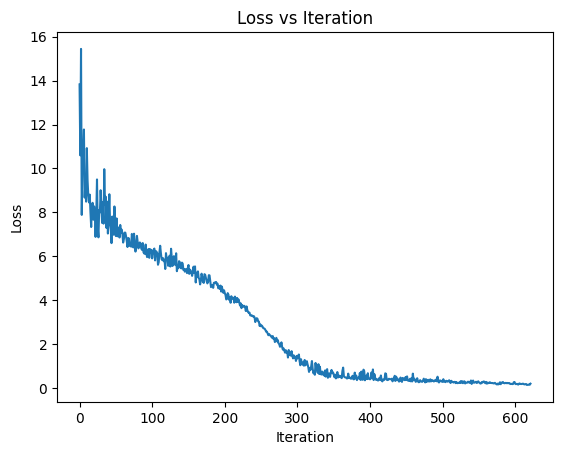

Epoch 2/5, Pre Train Loss: 0.0358


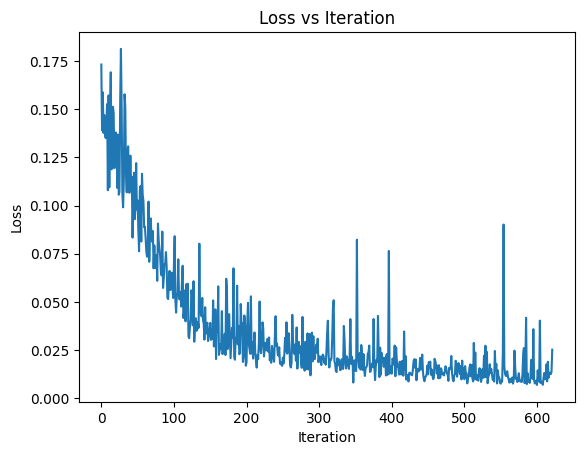

Epoch 3/5, Pre Train Loss: 0.0086


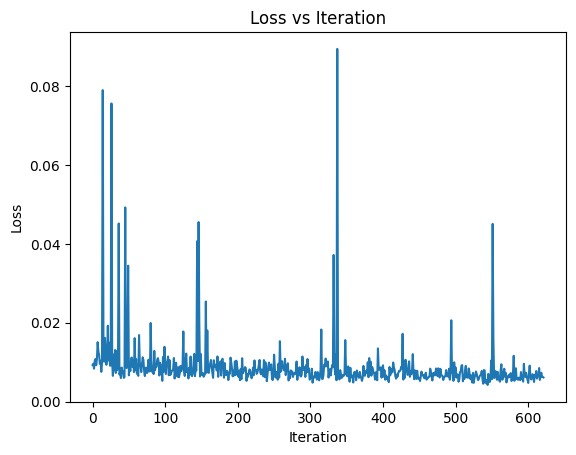

Epoch 4/5, Pre Train Loss: 0.0066


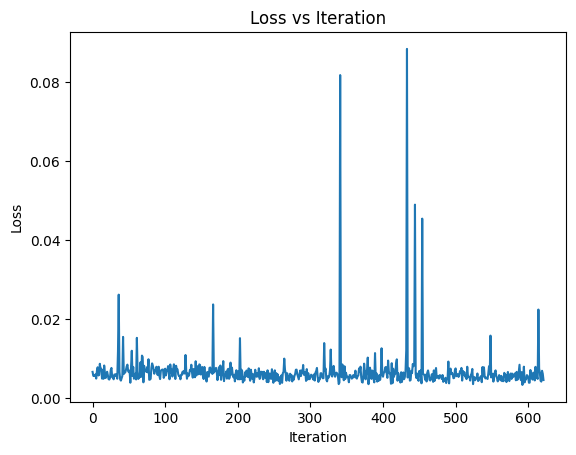

Epoch 5/5, Pre Train Loss: 0.0058


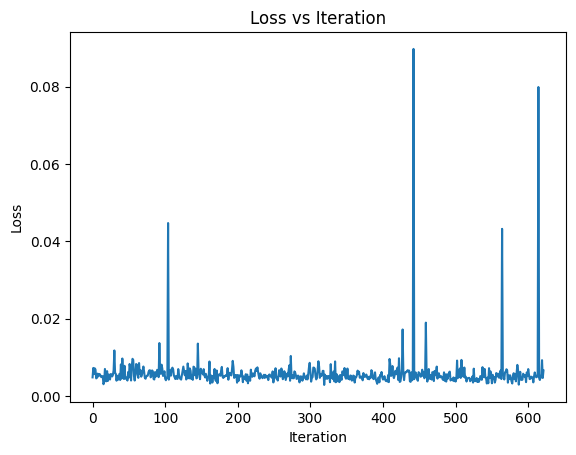

Epoch 1/3, Fine Tune Loss: 0.4446


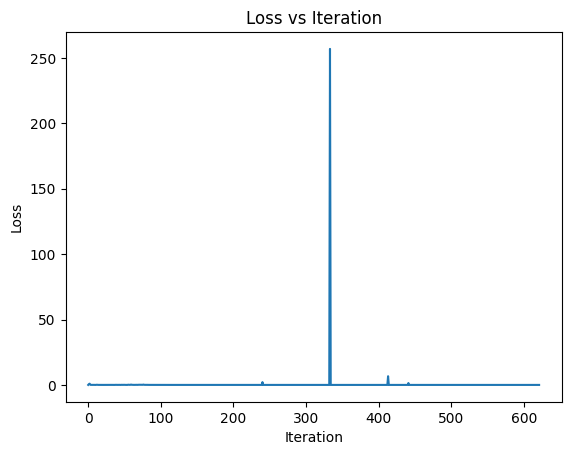

Epoch 2/3, Fine Tune Loss: 0.0456


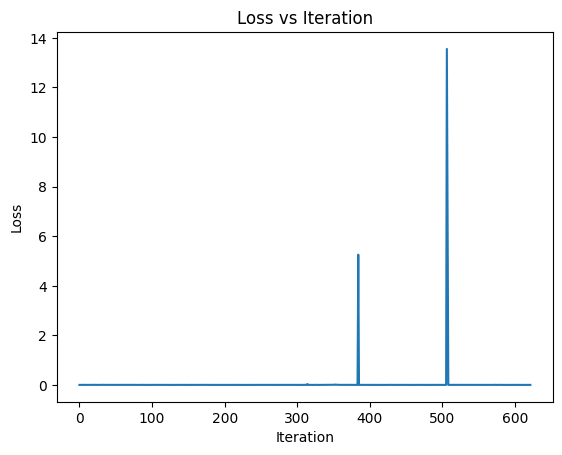

Epoch 3/3, Fine Tune Loss: 0.0535


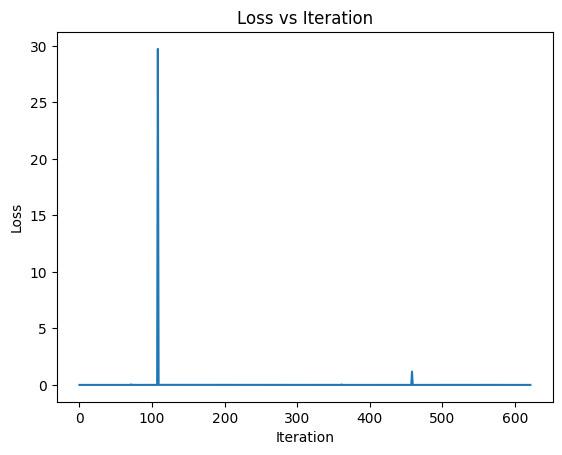

0.5140077132504086
Epoch 1/10, Fine Tune Loss: 0.0046


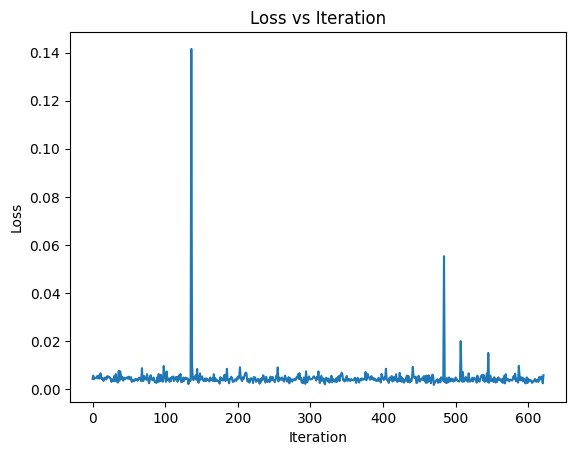

0.5245057227527213
Epoch 2/10, Fine Tune Loss: 0.0042


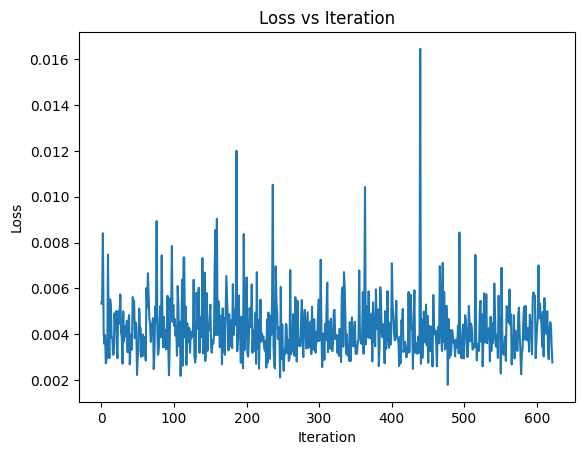

0.5322643929068298
Epoch 3/10, Fine Tune Loss: 0.0042


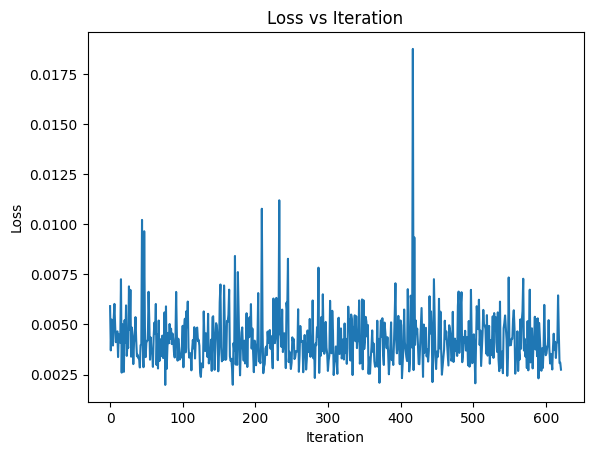

0.5382765847770348
Epoch 4/10, Fine Tune Loss: 0.0042


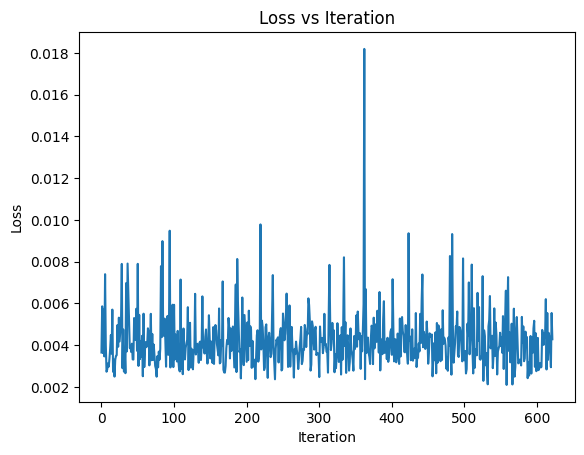

0.5368195912079029
Epoch 5/10, Fine Tune Loss: 0.0042


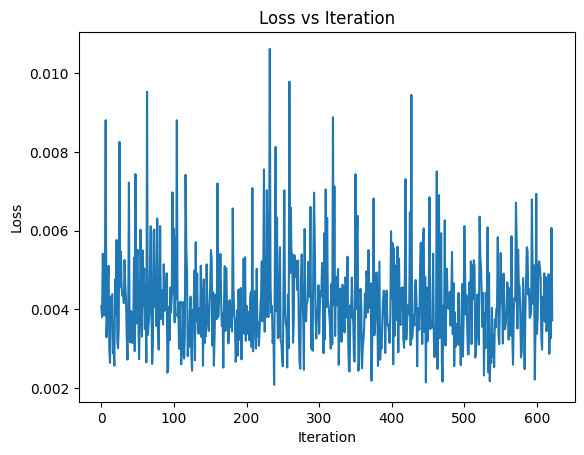

0.5383435729711386
Epoch 6/10, Fine Tune Loss: 0.0042


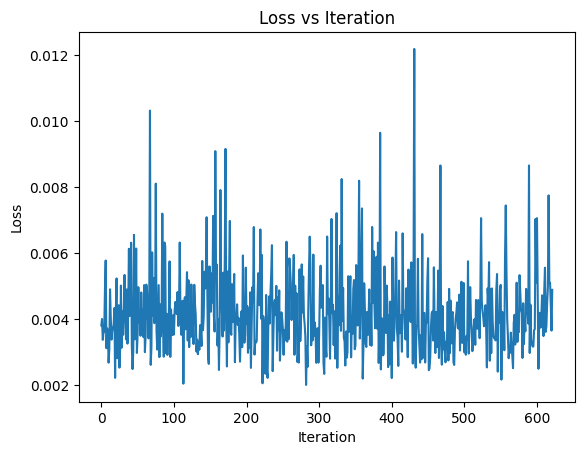

0.542740870470786
Epoch 7/10, Fine Tune Loss: 0.0042


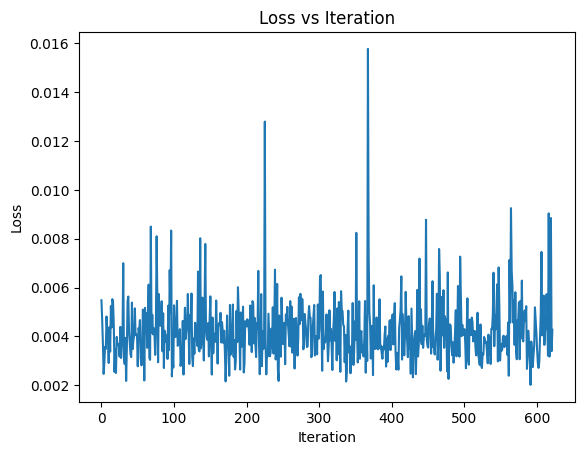

0.5354846118922402
Epoch 8/10, Fine Tune Loss: 0.0042


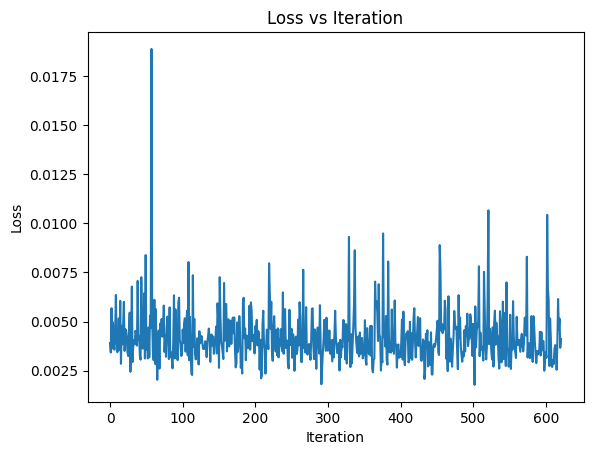

0.5433724736285747
Epoch 9/10, Fine Tune Loss: 0.0042


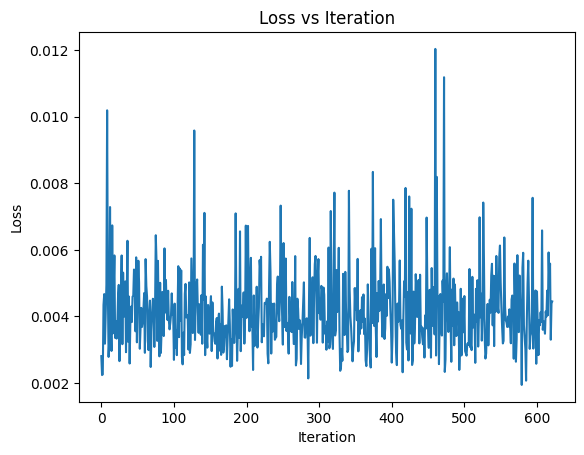

0.5487219606948436
Epoch 10/10, Fine Tune Loss: 0.0042


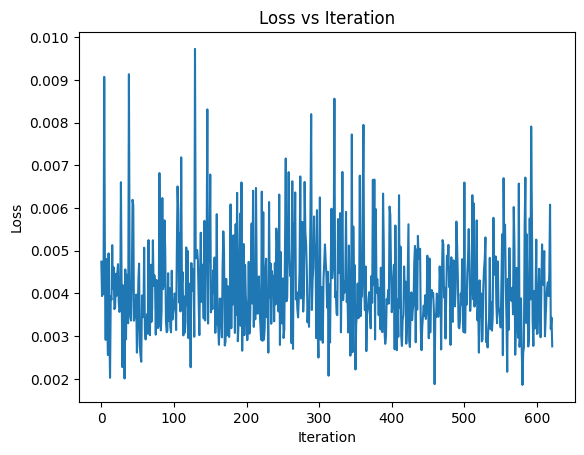

In [66]:
# Training loop
num_epochs = 5
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_epochs = []
for epoch in range(num_epochs):
    train_loss, loss_list = pre_train(model, train_loader, optimizer, criterion, device, dtype=torch.float)
    print(f"Epoch {epoch+1}/{num_epochs}, Pre Train Loss: {train_loss:.4f}")
    plt.plot(loss_list)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Loss vs Iteration')
    plt.show()
    loss_epochs.append(train_loss)

optimizer = optim.Adam(model.parameters(), lr=0.005)
criterion = nn.L1Loss()
num_epochs = 3
loss_epochs = []
for epoch in range(num_epochs):
    train_loss, loss_list = fine_tune_1(model, train_loader, optimizer, criterion, device, dtype=torch.float)
    print(f"Epoch {epoch+1}/{num_epochs}, Fine Tune Loss: {train_loss:.4f}")
    plt.plot(loss_list)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Loss vs Iteration')
    plt.show()
    loss_epochs.append(train_loss)

optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.L1Loss()
num_epochs = 10
loss_epochs = []
for epoch in range(num_epochs):
    train_loss, loss_list, accuracy = fine_tune_2(model, train_loader, optimizer, criterion, device, dtype=torch.float)
    print(accuracy)
    print(f"Epoch {epoch+1}/{num_epochs}, Fine Tune Loss: {train_loss:.4f}")
    plt.plot(loss_list)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Loss vs Iteration')
    plt.show()
    loss_epochs.append(train_loss)

torch.save(model, 'mamba_crypto.pt')


In [ ]:
!pip install backtesting

In [ ]:
import pandas as pd

def manipulate_data(data_array):
    manipulated = np.zeros((data_array.shape[0] - 2, 4))
    manipulated[:, 0] = data_array[2:, 0] / data_array[2:, 3]
    manipulated[:, 1] = data_array[2:, 1] / data_array[2:, 2]
    manipulated[:, 2] = np.array([data_array[i + 1, 0] / data_array[i + 2, 0] for i in range(data_array.shape[0] - 2)])
    manipulated[:, 3] = data_array[2:, 4] + 1e-8
    manipulated = np.log(manipulated)
    manipulated = np.concatenate([manipulated, np.expand_dims(manipulated[manipulated.shape[0] - 1], axis=0), np.expand_dims(manipulated[manipulated.shape[0] - 1], axis=0)])

    return manipulated

In [41]:
from backtesting import Strategy
from backtesting.lib import crossover

model.eval()
model = torch.load('mamba_crypto_min.pt')

class MambaPredict(Strategy):

    def init(self):
        self.model = model

    def next(self):
        if len(self.data.Close) >= 102:
            rolling_window = np.column_stack([self.data.Open[-102:], self.data.High[-102:], self.data.Low[-102:],
                                               self.data.Close[-102:], self.data.Volume[-102:]])

            # Manipulate the last 100 rows of data
            manipulated_data = manipulate_data(rolling_window)

            manipulated_data = torch.from_numpy(manipulated_data).to(device=device, dtype=torch.float).unsqueeze(0)

            # Predict using Mamba model on the latest data
            output = self.model(manipulated_data)
            prediction = torch.exp(output[:, -1, 2])
            current_time = self.data.index[-1]

            if prediction < 1/1.002:
                self.buy()

            elif prediction > 1.002/1:
                self.sell()

            for trade in self.trades:
                if current_time - trade.entry_time > 2:
                    trade.close()


<ipython-input-41-24e89f1e61d2>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('mamba_crypto_min.pt')


In [73]:
from backtesting import Backtest
import matplotlib.pyplot as plt


btc_data = pd.read_csv('BTC-Hourly.csv')
btc_data = btc_data[::-1].reset_index(drop=True)


test_dataset = btc_data[int(len(dataset) * 0.6):]

test_dataset = test_dataset.rename(columns={
    'open': 'Open',
    'high': 'High',
    'low': 'Low',
    'close': 'Close',
    'Volume BTC': 'Volume'
})

bt = Backtest(test_dataset, MambaPredict, cash=1000000, commission=.002)
stats = bt.run()

years = stats['Duration']/(365 * 24)
total_return = float(stats['Return [%]'])/100

yearly_return = ((1 + total_return) ** (1 / years) - 1) * 100

ydf = pd.Series([yearly_return], index=["Yearly Return [%]"])
stats = pd.Series(stats)
stats = stats._append(ydf)

bt.plot()
stats

<ipython-input-73-781e2d8f79f4>:19: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt = Backtest(test_dataset, MambaPredict, cash=1000000, commission=.002)
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


,0
Start,19893.0
End,33258.0
Duration,13365.0
Exposure Time [%],2.887925
Equity Final [$],1607235.30854
Equity Peak [$],1856946.93826
Return [%],60.723531
Buy & Hold Return [%],265.050309
Return (Ann.) [%],0.0
Volatility (Ann.) [%],NaN
